In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import AveragePooling2D , MaxPooling2D
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
# Replacing maxpool layer with Average pool because it performs better
def VGG_Average_pool(shape):
    vgg = VGG16(input_shape = shape , include_top= False , weights = "imagenet")

    model = Sequential()

    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            model.add(AveragePooling2D())
            
        else:
            model.add(layer)
    
    return model

In [3]:
## gram_matrix for style loss
def gram_matrix(x):
    x = K.batch_flatten(K.transpose(x))
    G = K.dot(x , K.transpose(x)) / x.get_shape().num_elements()

    return G

In [4]:
def scale_img(x):
    x = x - x.min()
    x = x / x.max()

    return x

In [5]:
def unpreprocess(img):
    img[... , 0] += 103.99
    img[... , 1] += 116.779
    img[... , 2] += 126.68
    img = img[... , :: -1]

    return img

In [6]:
def style_loss(output , target):
    loss = K.mean(K.square(gram_matrix(output) - gram_matrix(target)))
    return loss

In [7]:
def content_loss(output , target):
    loss = K.mean(K.square(output - target))
    return loss

### Reading images

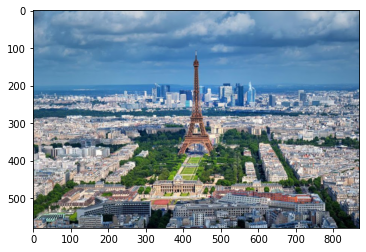

In [92]:
content_image = plt.imread("eiffel1.jpg")
plt.imshow(content_image)
content_image = np.expand_dims(content_image , axis = 0)
content_image = preprocess_input(content_image)
shape = content_image[0].shape
batch_shape = content_image.shape

In [93]:
shape

(580, 870, 3)

In [94]:
shape[:-1]

(580, 870)

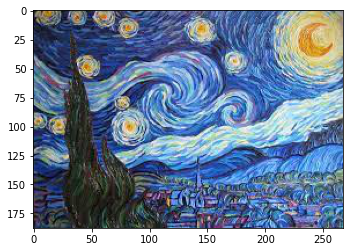

In [95]:
style_image = plt.imread("starry night.jpg")
plt.imshow(style_image)
style_image = cv2.resize(style_image , shape[:-1][::-1])
style_image = np.expand_dims(style_image , axis = 0)
style_image = preprocess_input(style_image)

In [96]:
vgg = VGG_Average_pool(shape)
vgg.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 580, 870, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 580, 870, 64)      36928     
_________________________________________________________________
average_pooling2d_20 (Averag (None, 290, 435, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 290, 435, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 290, 435, 128)     147584    
_________________________________________________________________
average_pooling2d_21 (Averag (None, 145, 217, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 145, 217, 256)    

In [97]:
content_model = Model(vgg.input , vgg.layers[13].output)
content_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 580, 870, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 580, 870, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 580, 870, 64)      36928     
_________________________________________________________________
average_pooling2d_20 (Averag (None, 290, 435, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 290, 435, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 290, 435, 128)     147584    
_________________________________________________________________
average_pooling2d_21 (Averag (None, 145, 217, 128)     0   

In [98]:
symbolic_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith("conv1")]

In [99]:
symbolic_outputs

[<tf.Tensor 'block1_conv1_9/Relu:0' shape=(None, 580, 870, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_9/Relu:0' shape=(None, 290, 435, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_9/Relu:0' shape=(None, 145, 217, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_9/Relu:0' shape=(None, 72, 108, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_9/Relu:0' shape=(None, 36, 54, 512) dtype=float32>]

In [100]:
style_model = Model(vgg.input , symbolic_outputs)
style_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 580, 870, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 580, 870, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 580, 870, 64)      36928     
_________________________________________________________________
average_pooling2d_20 (Averag (None, 290, 435, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 290, 435, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 290, 435, 128)     147584    
_________________________________________________________________
average_pooling2d_21 (Averag (None, 145, 217, 128)     0   

In [101]:
content_target = K.variable(content_model.predict(content_image))
style_target = [K.variable(y) for y in style_model.predict(style_image)]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [102]:
style_target

[<tf.Variable 'Variable_19:0' shape=(1, 580, 870, 64) dtype=float32>,
 <tf.Variable 'Variable_20:0' shape=(1, 290, 435, 128) dtype=float32>,
 <tf.Variable 'Variable_21:0' shape=(1, 145, 217, 256) dtype=float32>,
 <tf.Variable 'Variable_22:0' shape=(1, 72, 108, 512) dtype=float32>,
 <tf.Variable 'Variable_23:0' shape=(1, 36, 54, 512) dtype=float32>]

## defining loss

In [103]:
loss = 30 * content_loss(content_model.output , content_target)
weights = [1 ,2 ,3 ,4 ,5]
for w , output , target in zip(weights , symbolic_outputs , style_target):
    loss += w*style_loss(output[0] ,  target[0])

## defining gradients 

In [104]:
grads = K.gradients(loss , vgg.input)

### function to return loss and grads

In [105]:
get_loss_and_grads = K.function(
                     inputs = vgg.input,
                     outputs = [loss] + grads
                    )

# function to return loss and grads as vector since l_bfgs_b excepts vector

def loss_grads_wrapper(x_vec):
    l , g = get_loss_and_grads(x_vec.reshape(*batch_shape))
    return l.astype(np.float64) , g.flatten().astype(np.float64)

In [106]:
from scipy.optimize import fmin_l_bfgs_b

epochs - 0 --- loss - 13801.982421875


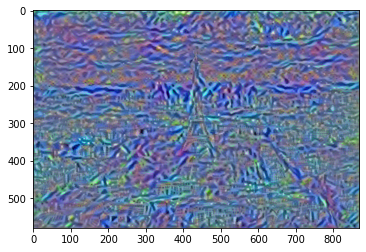

epochs - 1 --- loss - 5328.8486328125


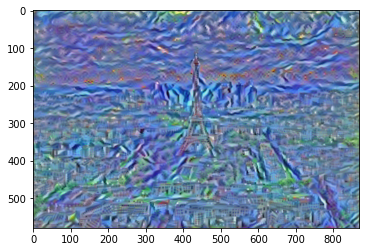

epochs - 2 --- loss - 3972.5888671875


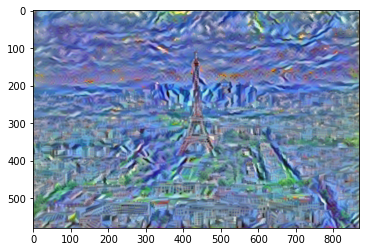

epochs - 3 --- loss - 3358.145751953125


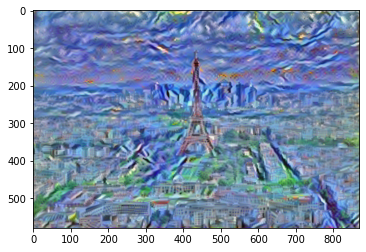

epochs - 4 --- loss - 2971.808837890625


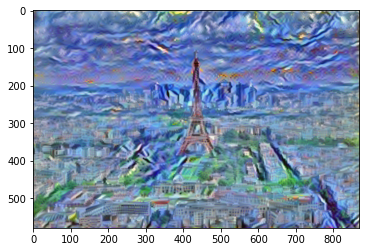

epochs - 5 --- loss - 2710.954345703125


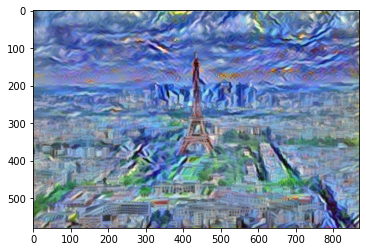

epochs - 6 --- loss - 2503.3193359375


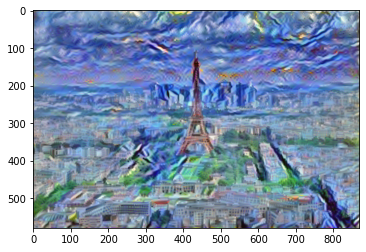

epochs - 7 --- loss - 2340.7646484375


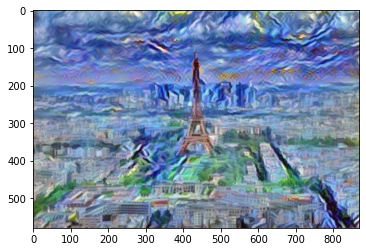

epochs - 8 --- loss - 2214.946533203125


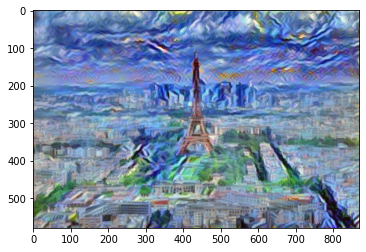

epochs - 9 --- loss - 2114.12060546875


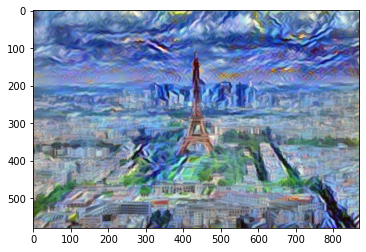

In [107]:
# x = np.random.randn(np.prod(batch_shape))
x = np.random.randn(np.prod(batch_shape))
losses = []

for i in range(10):
    x , l , _ = fmin_l_bfgs_b(
                func = loss_grads_wrapper,
                x0 = x, 
                maxfun = 30
                )
    x = np.clip(x , -127 , 127)
    losses.append(l)
    print(f"epochs - {i} --- loss - {l}")
    w = x.copy()
    final_img = scale_img(unpreprocess(w.reshape(*batch_shape)))

    plt.imshow(final_img[0])
    plt.show()
final_img = scale_img(unpreprocess(x.reshape(*batch_shape)))